## XGBoost

In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

### Import data

In [ ]:
df_train = pd.read_parquet("./data/data_train_borderline_smote.parquet")
df_val = pd.read_parquet("./data/data_val.parquet")
df_test = pd.read_parquet("./data/data_test.parquet")

In [14]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values
X_val = df_val.iloc[:, 1:].values
y_val = df_val.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

### Define model

In [15]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)

### Model tuning

In [16]:
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': np.logspace(-3, 0, 10),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': np.linspace(0, 5, 6)
}

In [17]:
best_model = None
best_score = -np.inf
best_params = None

for _ in range(50):  
    params = {key: np.random.choice(values) for key, values in param_dist.items()}
    model = xgb.XGBClassifier(**params, objective='binary:logistic', eval_metric='auc', random_state=42)
    model.fit(X_train, y_train)
    
    y_val_prob = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_prob)
    
    if roc_auc > best_score:
        best_score = roc_auc
        best_model = model
        best_params = params

### Best model

In [18]:
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.46415888336127775, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 4.0}


### Evaluate on validation set

In [19]:
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_val_prob)
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

In [20]:
print(f"Validation ROC-AUC: {roc_auc:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation ROC-AUC: 0.8168
Validation Accuracy: 0.8423


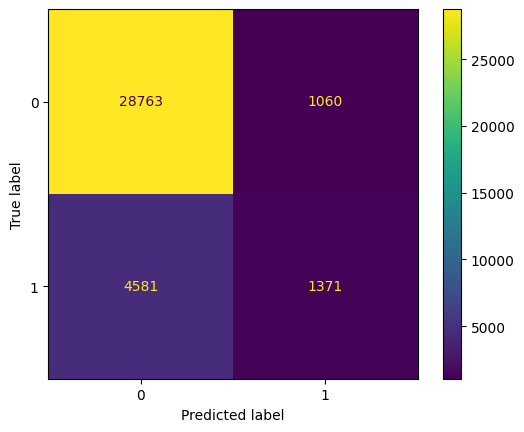

In [21]:
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

### Evaluate on test set

In [22]:
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

In [23]:
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test ROC-AUC: 0.8138
Test Accuracy: 0.8432


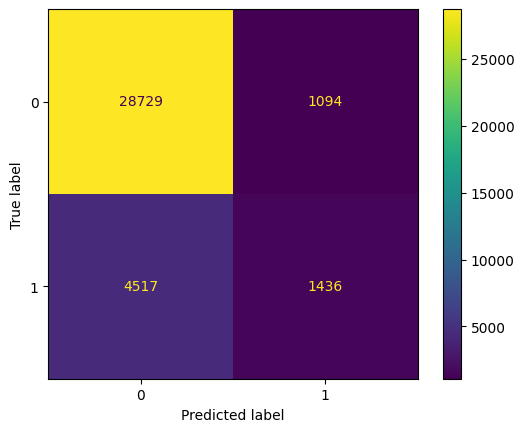

In [24]:
test_disp = ConfusionMatrixDisplay(test_conf_matrix)
test_disp.plot()

### Conclusion
* Since the test AUC and accuracy are 0.8138 and 0.8432, respectively, the fitted XGBoost model outperforms all the models fitted by Xie et al (2019).

### Reference
* Xie, Zidian, et al. "Building risk prediction models for type 2 diabetes using machine learning techniques." Preventing chronic disease 16 (2019): E130.